In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# loading the data
df_telecom = pd.read_csv("/content/drive/MyDrive/week-2/telecom.csv")
df_telecom.head()

,Unnamed: 0,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [7]:
# Sesions frequency
sessions_frequency = df_telecom.groupby('IMSI')['Bearer Id'].nunique()


In [8]:
# Duration of the sesion
session_duration = df_telecom.groupby('IMSI')['Dur. (ms)'].sum()

In [9]:
# sesions total trafic
total_traffic = df_telecom.groupby('IMSI').agg({'Total DL (Bytes)': 'sum', 'Total UL (Bytes)': 'sum'})

In [11]:
# combining sll metrics

engagement_metrics = pd.DataFrame({
    'Sessions Frequency': sessions_frequency,
    'Total Duration (ms)': session_duration,
    'Total DL (Bytes)': total_traffic['Total DL (Bytes)'],
    'Total UL (Bytes)': total_traffic['Total UL (Bytes)'],
})


In [12]:
# top 10 costomers in each metrics
top_10_sessions = engagement_metrics.nlargest(10, 'Sessions Frequency')
top_10_duration = engagement_metrics.nlargest(10, 'Total Duration (ms)')
top_10_dl = engagement_metrics.nlargest(10, 'Total DL (Bytes)')
top_10_ul = engagement_metrics.nlargest(10, 'Total UL (Bytes)')

**Normalize Metrics and Run K-Means Clustering**

In [14]:
# normalizing metrics
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(engagement_metrics[['Sessions Frequency', 'Total Duration (ms)', 'Total DL (Bytes)', 'Total UL (Bytes)']])

In [16]:
# Run K-means clustering
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
engagement_metrics['Cluster'] = kmeans.fit_predict(normalized_metrics)

In [17]:
# compute metricses for each cluster
cluster_summary = engagement_metrics.groupby('Cluster').agg({
    'Sessions Frequency': ['min', 'max', 'mean', 'sum'],
    'Total Duration (ms)': ['min', 'max', 'mean', 'sum'],
    'Total DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Total UL (Bytes)': ['min', 'max', 'mean', 'sum'],
}).reset_index()

**Visualize Results **

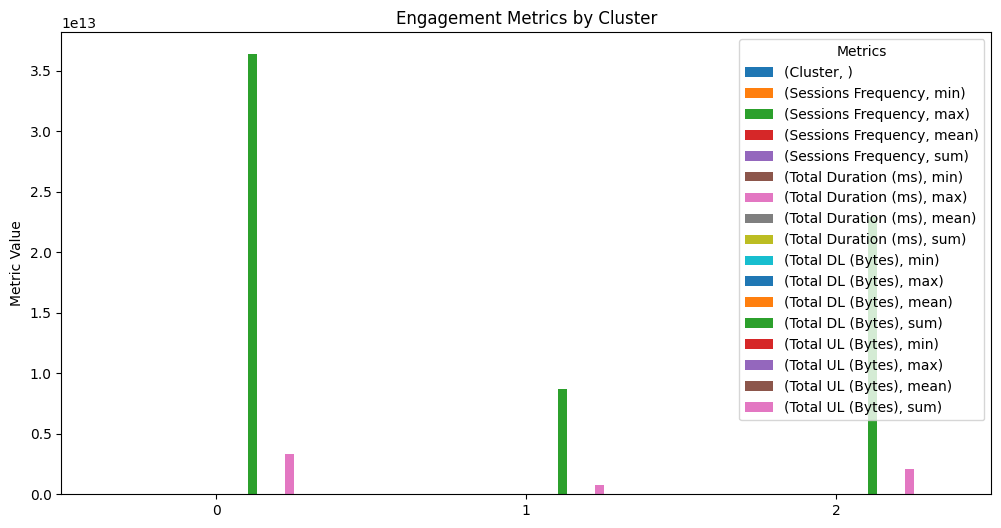

In [18]:
# Plot cluster summary
cluster_summary.plot(kind='bar', figsize=(12, 6))
plt.title('Engagement Metrics by Cluster')
plt.ylabel('Metric Value')
plt.xticks(rotation=0)
plt.legend(title='Metrics')
plt.show()

**Aggregate User trafffic per application**

In [21]:
# Assuming you have application columns in the dataset
applications = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']
traffic_per_app = df_telecom.groupby('MSISDN/Number')[applications].sum()

In [23]:
# Top 10 most engaging users
top_users_per_app = {app: traffic_per_app.nlargest(10, app) for app in applications}

**Plot Top 3 most used Application**

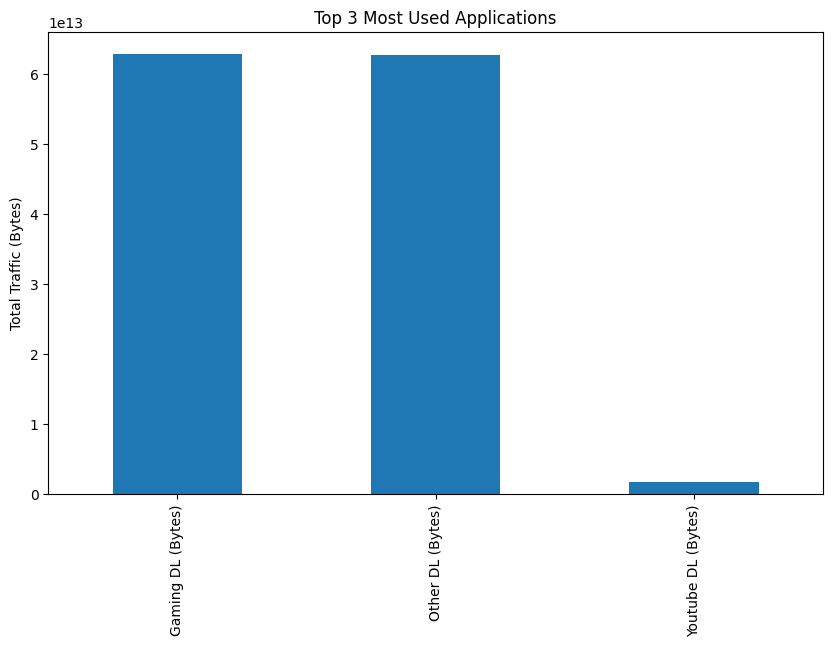

In [24]:
# Top 3 most used apps
top_applications = traffic_per_app.sum().nlargest(3)
top_applications.plot(kind='bar', figsize=(10, 6))
plt.title('Top 3 Most Used Applications')
plt.ylabel('Total Traffic (Bytes)')
plt.show()

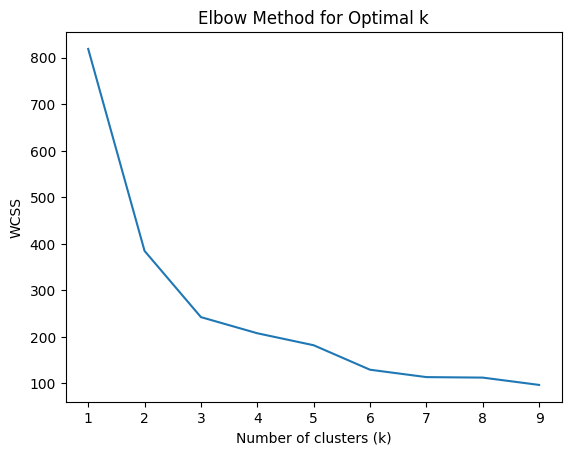

In [25]:
# Optimizing K for clustering
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(normalized_metrics)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 10), wcss)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()